<a href="https://colab.research.google.com/github/quannguyen2704/bt-mtcnn-cnn/blob/main/bt_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.0000e+00 - loss: 1.6076 - val_accuracy: 0.0000e+00 - val_loss: 2.2486
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7500 - loss: 1.1995 - val_accuracy: 0.0000e+00 - val_loss: 5.8719
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5000 - loss: 2.5600 - val_accuracy: 0.0000e+00 - val_loss: 3.8322
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.0000e+00 - loss: 2.0188 - val_accuracy: 0.0000e+00 - val_loss: 2.3543
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.2500 - loss: 1.6208 - val_accuracy: 0.0000e+00 - val_loss: 1.8518
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5000 - loss: 1.4675 - val_accuracy: 0.0000e+00 - val_loss: 1.7933
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.2500 - loss: 1.5470 - val_accuracy: 0.0000e+00 - val_loss: 1.8216
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.2500 - loss: 1.5709 

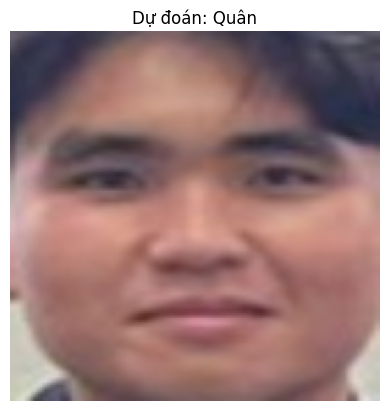

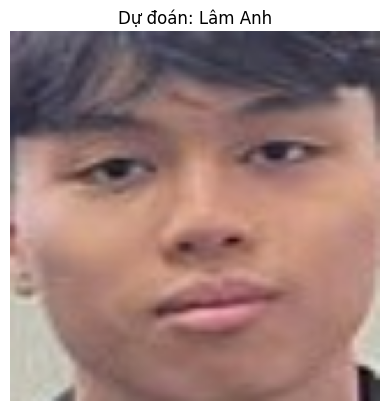

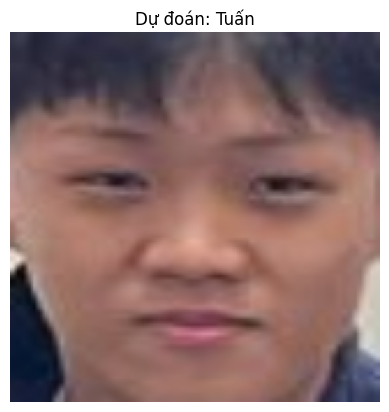

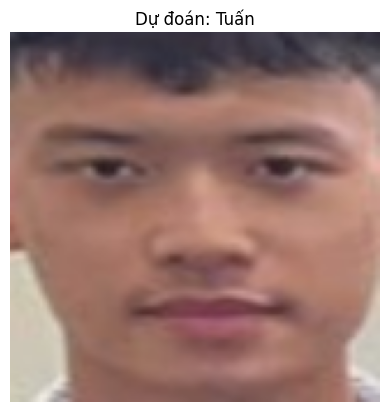

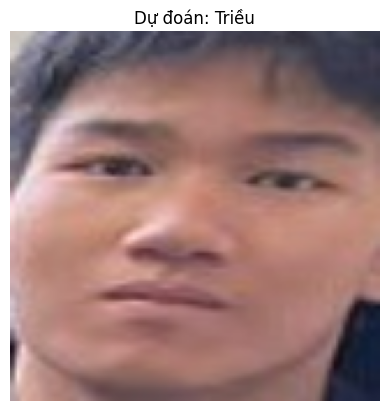

In [36]:

from mtcnn import MTCNN
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical

output_dir = "/content/data"
os.makedirs(output_dir, exist_ok=True)

filename = "/content/anh nhom.jpg"
image = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
detector = MTCNN()
faces = detector.detect_faces(image)

names = ['Nhân', 'Triều', 'Quân', 'Lâm Anh', 'Tuấn']

for i, face in enumerate(faces):
    if i >= len(names):
        break

    name = names[i]
    save_path = os.path.join(output_dir, f"{name}.jpg")

    if os.path.exists(save_path):
        continue

    x, y, w, h = face['box']
    x, y = max(0, x), max(0, y)
    face_crop = image[y:y+h, x:x+w]
    face_crop = cv2.resize(face_crop, (160, 160))
    cv2.imwrite(save_path, cv2.cvtColor(face_crop, cv2.COLOR_RGB2BGR))


X, y, label_map = [], [], {}
for i, filename in enumerate(os.listdir(output_dir)):
    if filename.endswith(".jpg"):
        path = os.path.join(output_dir, filename)
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        img = img.astype('float32') / 255.0
        X.append(img)

        name = filename.split(".")[0]
        if name not in label_map:
            label_map[name] = len(label_map)
        y.append(label_map[name])

X = np.array(X)
y = np.array(y)


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=len(label_map))
y_test = to_categorical(y_test, num_classes=len(label_map))

input_layer = Input(shape=(160, 160, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(label_map), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=300, validation_data=(x_test, y_test))


model.evaluate(x_test, y_test)


def predict_image(image_path, model, label_map, detector):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f" Không thể đọc được ảnh: {image_path}")
        return

    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(img)

    if not faces:
        print(f" Không tìm thấy khuôn mặt nào trong ảnh: {image_path}")
        return

    for i, face in enumerate(faces):
        x, y, w, h = face['box']
        x, y = max(0, x), max(0, y)
        face_crop = img[y:y+h, x:x+w]
        resized_face = cv2.resize(face_crop, (160, 160))

        face_input = resized_face.astype('float32') / 255.0
        face_input = np.expand_dims(face_input, axis=0)

        prediction = model.predict(face_input, verbose=0)
        predicted_label = np.argmax(prediction)
        predicted_name = list(label_map.keys())[list(label_map.values()).index(predicted_label)]

        plt.imshow(resized_face)
        plt.axis('off')
        plt.title(f"Dự đoán: {predicted_name}")
        plt.show()

# 10. Dự đoán thử trên các ảnh
predict_image("/content/quan.jpg", model, label_map, detector)
predict_image("/content/lamanh.jpg", model, label_map, detector)
predict_image("/content/nhan.jpg", model, label_map, detector)
predict_image("/content/tuan.jpg", model, label_map, detector)
predict_image("/content/trieu.jpg", model, label_map, detector)
